In [1]:
import copy
import random
from pprint import pprint
from itertools import chain

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from transformers import AutoModel, AutoTokenizer
import datasets

import wandb
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import class_attention as cat

%load_ext autoreload
%autoreload 2


def detorch(x):
    return x.detach().cpu().numpy()

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
news_dataset = datasets.load_dataset("Fraser/news-category-dataset")

Using custom data configuration default
Reusing dataset news_category (/home/vlialin/.cache/huggingface/datasets/news_category/default/0.0.0/737b7b6dff469cbba49a6202c9e94f9d39da1fed94e13170cf7ac4b61a75fb9c)


In [11]:
from collections import Counter

<BarContainer object of 41 artists>

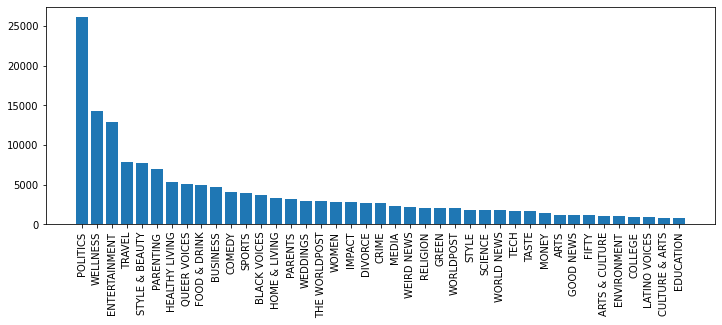

In [15]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
counts = Counter(news_dataset['train']['category'])
plt.bar(*zip(*counts.most_common()))

In [97]:
model_name = 'distilbert-base-uncased'
bert = transformers.AutoModel.from_pretrained(model_name)
bert_tok = transformers.AutoTokenizer.from_pretrained(model_name)

In [98]:
type(class_names_input)

dict

In [99]:
class_names = list(counts.keys())
class_names_input_dict = bert_tok.batch_encode_plus(class_names, return_tensors='pt')
h, = bert(class_names_input_dict['input_ids'])
embeds = h[:, 0]
embeds.shape

torch.Size([41, 768])

In [100]:
norms = torch.sum(embeds * embeds, dim=1)
norms = norms.detach().cpu().numpy()
norms

array([121.95278 , 213.36237 , 129.22359 , 146.4061  , 116.63533 ,
       113.745834, 139.66342 , 111.283905, 126.71154 , 260.32318 ,
       183.49704 , 100.28499 , 128.83908 , 166.09364 , 103.81252 ,
       136.25174 , 141.91252 , 105.755585,  96.10967 , 109.29761 ,
       150.73991 ,  92.1807  , 105.34024 , 164.0588  , 197.52014 ,
       127.76573 , 127.965   ,  91.86194 , 130.27469 ,  88.81395 ,
       186.0834  , 130.62695 , 183.88087 , 119.20833 , 140.82944 ,
       137.48457 , 120.318146, 148.34018 , 106.13847 , 100.96348 ,
        94.717545], dtype=float32)

Text(0, 0.5, 'CLS token Eucledian norm')

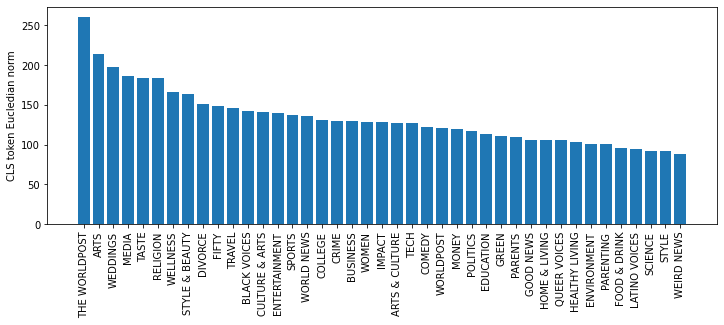

In [106]:
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)

norms_sorted, class_names_sorted_by_norm = zip(*sorted(zip(norms, class_names), reverse=True))
plt.bar(class_names_sorted_by_norm, norms_sorted)
plt.ylabel('CLS token Eucledian norm')

In [102]:
def normalize_embeds(embeds):
    return embeds / torch.sqrt(torch.sum(embeds * embeds, dim=1, keepdim=True))

In [103]:
embeds_normalized = normalize_embeds(embeds)
torch.sum(embeds_normalized * embeds_normalized, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)